# Derivative Analytics Library

## Background Environment Setup

In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
%matplotlib inline

In [2]:
def get_YearDelta(date, day_count=365):
    # return a ndarray contains day deltas in year
    # Parameter:
    '''
    date (array of datetime)
    day_count(float): number of days for a year
    '''
    YearDelta = [(x-date[0]).days/day_count for x in date]
    return np.array(YearDelta)

In [4]:
# test get_YearDelta function with 2016/1/1, 2016/4/1, 2016/7/1, 2016/10/1
date = [dt.datetime(2016,1,1),dt.datetime(2016,4,1),dt.datetime(2016,7,1),dt.datetime(2016,10,1)]
get_YearDelta(date)

array([ 0.        ,  0.24931507,  0.49863014,  0.75068493])

### Short Curve Class

In [5]:
class const_rate(object):
    # a const_rate class 
    # Attribute:
    '''
    name (string): name of the instance
    short_rate (float): the constant short rate
    '''
    def __init__(self, name, short_rate):
        # default initialization
        self.name=name
        self.short_rate=short_rate
        
    def get_discount_factor(self, date, dttype=True):
        # return an array of discount factor along with days delta in a row
        if dttype is True:
            dlist=get_YearDelta(date)
        else:
            dlist=date
        dflist = np.exp(self.short_rate*np.sort(-dlist))
        return np.array((date,dflist)).T      

In [10]:
# Test the const_rate class
conrate = const_rate('conrate', 0.05)
conrate.get_discount_factor(date)

array([[datetime.datetime(2016, 1, 1, 0, 0), 0.96316143217545],
       [datetime.datetime(2016, 4, 1, 0, 0), 0.9753767163648953],
       [datetime.datetime(2016, 7, 1, 0, 0), 0.9876116222305686],
       [datetime.datetime(2016, 10, 1, 0, 0), 1.0]], dtype=object)

In [14]:
class nonconst_rate(object):
    # a nonconst_rate class takes two sequence as rate and time
    # Attribute:
    '''
    name (string): name of the instance
    short_rate (ndarray): the array of short rate
    date (ndarray): the array of the date
    '''
    def __init__(self, name, short_rate, date):
        # default initialization
        self.name=name
        self.short_rate=short_rate
        self.date = date
    
    def get_discount_factor(self,dttype=True):
        if dttype is True:
            dlist = get_YearDelta(self.date)
        else:
            dlist = np.array(self.date)
        dflist = np.exp(self.short_rate*np.sort(-dlist))
        return np.array((date,dflist)).T   
    
    def get_interp_graph(self):
        time = get_YearDelta(self.date)
        rate = self.short_rate
        f = interp1d(time,rate,kind = 'cubic')
        xnew = np.linspace(0,np.max(time), num=40, endpoint=True)
        fig = plt.plot(xnew,f(xnew),'-',linewidth=0.5)
        plt.plot(time,rate,'ro')
        plt.plot(time,rate,'--',linewidth=0.5)
        plt.legend(['cubic','data'],loc='best')
        return fig

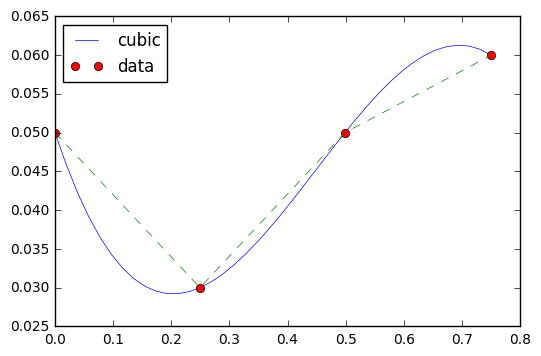

In [16]:
# Test the nonconst_rate class
short = np.array([0.05,0.03,0.05,0.06])
rate = nonconst_rate('rate',short, date)
rate.get_discount_factor()
fig = rate.get_interp_graph()

### Market Environment 

In [50]:
class mar_env(object):
    # a class holder for relative market environment 
    # attributes:
    '''
    name (string): object name
    pricing_date (datetime): date of the market environment
    constants (dictionary): model parameter such as volatility, risk free rate, etc. It can be a single object or an array
    lists (dictionary): list of risky securities, such as stock etc
    curves (dictionary): used to hold discounting cruve
    '''
    # methods:
    def __init__(self, name, price_date):
        self.name = name
        self.price_date = price_date
        self.constants={}
        self.lists={}
        self.curves={}
        
    def add_constants(self,key,constant):
        # constats as an attribute can be used to hold constant parameters.
        self.constants[key] = constant    
    def get_constants(self,key):
        return self.constants[key]
    
    def add_lists(self, key, list_object):
        # lists as an attribute can be used to hold securities.
        self.lists[key] = list_object        
    def get_lists(self, key):
        return self.lists[key]
    
    def add_curves(self, key, curve):
        # curves as an attribute can be used to hold short rate object.
        self.curves[key] = curve        
    def get_curves(self,key):
        return self.curves[key]
    
    def add_env(self, env):
        for key in env.constants:
            self.constants[key] = env.constants[key]
        for key in env.lists:
            self.lists[key] = env.lists[key]
        for key in env.curves:
            self.curves[key] = env.curves[key]
    
    def print_env(self):
        # print out all relevant market environment information
        print(self.name, '(Pricing Date: ', self.price_date, ')\n')
        print('constants:')
        print(self.constants, '\n')
        print('lists: ')
        print(self.lists, '\n')
        print('curves: ')
        print(self.curves)
        

In [51]:
# test market objects
market1 = mar_env('market1', dt.datetime(2015,1,1))
market1.add_lists('symbols', ['AAPL','MSFT','FB'])
market1.add_lists('symbols2',['NFLX','MS','GS'])
market1.add_curves('short_rate',rate)
market1.get_curves('short_rate')
market1.add_constants('volatility',0.3)
market1.add_constants('riskfree', 0)
market1.print_env()

market1 (Pricing Date:  2015-01-01 00:00:00 )

constants:
{'riskfree': 0, 'volatility': 0.3} 

lists: 
{'symbols': ['AAPL', 'MSFT', 'FB'], 'symbols2': ['NFLX', 'MS', 'GS']} 

curves: 
{'short_rate': <__main__.nonconst_rate object at 0x10d06be80>}


## Simulation

In [53]:
def sn_generator(dim, antithetic = True, moment_matching = True, fixed_seed = False):
    # Used to generate random number with input dimension
    # Parameters:
    '''
    dim (tuple): 3 dim tuple that defines the dimension of the random number
    antithetic: True if antithetic variance deduction method is applied
    moment_matching: True if moment_matchign variance deduction method is applied
    '''
    if fixed_seed is True:
        np.random.seed(10)
    if antithetic is True:
        rn = np.random.standard_normal((dim[0],dim[1],dim[2]/2))
        rn = np.concatenate((ran,-ran),axis=2)
    else:
        rn = np.random.standard_normal(dim)
    if moment_matching is True:
        rn = rn-np.mean(rn)
        rn = rn/np.std(rn)
    if dim[0] ==1:
        return rn[0]
    else:
        return rn

In [58]:
# Test sn_generator
snrn = sn_generator((3,4,4),antithetic=False,moment_matching=False,fixed_seed=True)
print('random number generated: ')
print(snrn)
print('mean: ', snrn.mean())
print('std: ', snrn.std())

random number generated: 
[[[ 1.3315865   0.71527897 -1.54540029 -0.00838385]
  [ 0.62133597 -0.72008556  0.26551159  0.10854853]
  [ 0.00429143 -0.17460021  0.43302619  1.20303737]
  [-0.96506567  1.02827408  0.22863013  0.44513761]]

 [[-1.13660221  0.13513688  1.484537   -1.07980489]
  [-1.97772828 -1.7433723   0.26607016  2.38496733]
  [ 1.12369125  1.67262221  0.09914922  1.39799638]
  [-0.27124799  0.61320418 -0.26731719 -0.54930901]]

 [[ 0.1327083  -0.47614201  1.30847308  0.19501328]
  [ 0.40020999 -0.33763234  1.25647226 -0.7319695 ]
  [ 0.66023155 -0.35087189 -0.93943336 -0.48933722]
  [-0.80459114 -0.21269764 -0.33914025  0.31216994]]]
mean:  0.0980537207591
std:  0.916390229175


In [61]:
class simulation_class(object):
    # attributes:
    '''
    name (string): class name
    mar_env (object): instance of market_environment
    corr (boolean): True if correlated with other model object
    '''
    
    '''
    Madatory parameter that should be passed from the mar_env class:
     price date, 
     from constants attribute: final_date, frequency, volatility, initial_value
     from curves attribuet: discoung_curve
     
    Optional parameter that should be passed from the mar_env class:
     from lists attribute: 
        time_grid, cholesky_matrix, rn_set, random_nember
     
    '''
    # methods:
    def __init__(self, name, mar_env, corr):
        try:
            self.name = name
            self.price_date = mar_env.price_date
            self.final_date = mar_env.get_constants('final_date')
            self.frequency = mar_env.get_constants('frequency')
            self.volatility = mar_env.get_constants('volatility')
            self.initial_value = mar_env.get_constants('initial_value')
            self.discount_curve = mar_env.get_curves('discount_curve')
            self.correlated = corr
            if corr is True:
                self.cholesky_matrix = mar_env.get_lists('cholesky_matrix')
                self.rn_set = mar_env.get_lists('rn_set')[self.name]
                self.random_numbers = mar_env.get_lists('random_numbers')
            try:
                self.time_grid = mar_env.get_lists('time_grid')
            except:
                self.time_grid=None
        except:
            print('Necessary information missing')
    
    def time_grid_generator(self):
        # it generate a equally intervaled time grid for simulation.
        # one thing should be noted is that it this function didn't return anything
        start = self.price_date
        end = self.final_date
        time_grid=pd.date_range(start=start, end=end,freq=self.frenncy).topydatetime()
        time_grid=list(time_grid)
        self.time_grid = np.array(time_grid)
    
    
    def get_instrument_values(self, fixed_seed = True):
        self.generate_paths(fixed_seed = fixed_seed, day_count=365)
        return self.instrument_values       